In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

from common import loss_utils

import sys
sys.path.append('./dgmr_original')
import dgmr

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/data_good_sun_2020.npz')
f = np.load(p)
times = f['times']
data = f['data']


In [11]:
p = pathlib.Path('data/data_good_sun_2021.npz')
f = np.load(p)
times2 = f['times']
data2 = f['data']

In [76]:
SAVE_FOLDER = 'dgmr_goodsun'

In [12]:
times.shape, data.shape, times2.shape, data2.shape

((32635,), (32635, 325, 400), (30026,), (30026, 325, 400))

In [13]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [71]:
# since all images are 5min apart, this would be 3 hours ahead
# we use this to make a 3 hour slice of the data
_INDEX_LOOKAHEAD = 35

def check_times(tstart, tend):
    # makes sure it is a 3 hour window
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times_l, data_l, tsfm, random_state=7):
        self.times_l = times_l
        self.data_l = data_l
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        # if len(times) = 100, the length is actually: length = 100 - _INDEX_LOOKAHEAD
        # because at any index we will look at slice(index : index + _INDEX_LOOKAHEAD)
        self.data_per_l = [len(t) - _INDEX_LOOKAHEAD for t in self.times_l]
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, i):
        _times, _data, index = self._get_time_data_array(i)
        tend = _times[index + _INDEX_LOOKAHEAD]
        tstart = _times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((i + _INDEX_LOOKAHEAD) % len(self))
        # DGMR actually only needs the first 4 input timesteps + 24 to forecast
        all_data = _data[index:index+INPUT_STEPS+FORECAST]
        all_data = self._get_crop(all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y
    
    
    def _get_time_data_array(self, index):
        """
        Returns the time array and data array you should be using, and how to index into them.
        """
        if index < 0:
            index = len(self) + index
        prev = 0
        for i in range(len(self.data_per_l)):
            if prev <= index < prev + self.data_per_l[i]:
                # index - prev because that would be the index into this array
                return self.times_l[i], self.data_l[i], index - prev
            prev = self.data_per_l[i]
        raise ValueError(f'Could not retrieve index {index}')

    def __len__(self):
        return sum(len(t) - _INDEX_LOOKAHEAD for t in self.times_l)

ds = CustomTensorDataset((times, times2), (data, data2), tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [72]:
x, y = ds[0]

In [73]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

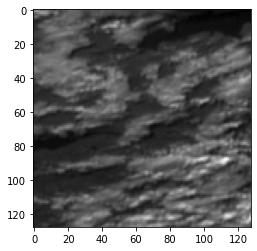

In [74]:
plt.imshow(x[-1], cmap='gray')

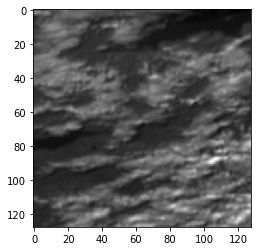

In [75]:
plt.imshow(y[0], cmap='gray')

In [77]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=384,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=384,
    context_channels=192,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
# model.load_state_dict(torch.load('weights/dgmr_full_128_msssim_notransform/dgmr_epochs=209_batch=1499_loss=0.2171.pt'))
model = model.to(DEVICE)



In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 13399657 trainable parameters


In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
msssim_criterion = loss_utils.MS_SSIMLoss(1023.0, channels=24)

In [80]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    savefreq = 1200 # save after this many batches
    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)
        preds = model(x)
        y = y * _STD_PIXEL + _MEAN_PIXEL
        preds = preds * _STD_PIXEL + _MEAN_PIXEL
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % savefreq == savefreq-1:
                torch.save(model.state_dict(), f'weights/{SAVE_FOLDER}/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')
                
    return epoch_loss / total_count




In [81]:
EPOCHS = 100
EXISTING = 0

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, msssim_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/{SAVE_FOLDER}/dgmr_epochs={i}_loss={avg_loss}.pt')


Epoch 1


  0%|          | 0/3912 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.2746, 0.2796): 100%|██████████| 3912/3912 [52:44<00:00,  1.24it/s]


Epoch 2


Avg Loss, Batch Loss: (0.2567, 0.189): 100%|██████████| 3912/3912 [53:01<00:00,  1.23it/s] 


Epoch 3


Avg Loss, Batch Loss: (0.2518, 0.236): 100%|██████████| 3912/3912 [52:59<00:00,  1.23it/s] 


Epoch 4


Avg Loss, Batch Loss: (0.2494, 0.2226): 100%|██████████| 3912/3912 [53:02<00:00,  1.23it/s]


Epoch 5


Avg Loss, Batch Loss: (0.2478, 0.2589): 100%|██████████| 3912/3912 [53:02<00:00,  1.23it/s]


Epoch 6


Avg Loss, Batch Loss: (0.2463, 0.2922): 100%|██████████| 3912/3912 [53:02<00:00,  1.23it/s]


Epoch 7


Avg Loss, Batch Loss: (0.2457, 0.1896): 100%|██████████| 3912/3912 [53:02<00:00,  1.23it/s]


Epoch 8


Avg Loss, Batch Loss: (0.2452, 0.2163):  19%|█▉        | 746/3912 [10:06<42:53,  1.23it/s]


KeyboardInterrupt: 

In [20]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [19]:
LOOKS = int(5000/BATCH_SIZE)

In [21]:
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    preds = []
    for _ in range(1):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
    
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

  0%|          | 0/312 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Score: 0.7807311997991905: : 313it [02:02,  2.56it/s]                       


In [22]:
scores = np.array(scores)
scores.mean()

0.7807311997991908

In [23]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.95559188, 0.92036054, 0.88966255, 0.86269325, 0.83943689,
       0.81971426, 0.80351024, 0.79000379, 0.77848016, 0.76899063,
       0.76120276, 0.75483571, 0.74961491, 0.74526883, 0.74171417,
       0.73855603, 0.73569226, 0.7330805 , 0.73069161, 0.72824245,
       0.72587696, 0.72360827, 0.7213976 , 0.71932255])

In [28]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

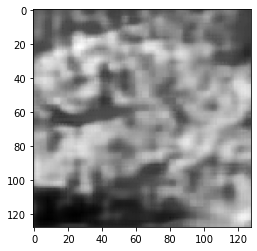

In [29]:
plt.imshow(out[0,0], cmap='gray')

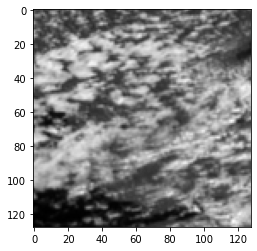

In [30]:
plt.imshow(true[0,0], cmap='gray')

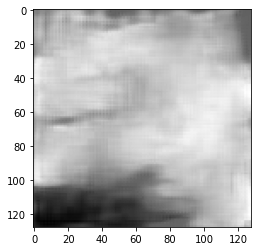

In [31]:
plt.imshow(out[0,-1], cmap='gray')

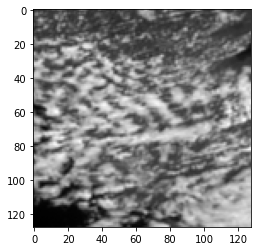

In [32]:
plt.imshow(true[0,-1], cmap='gray')